In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from matplotlib import rc
from numpy import inf

from AtlasCommonUtils import SetAtlasStyle
from ROOT import TLatex



rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)




#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

Welcome to JupyROOT 6.22/02


In [2]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [3]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [4]:
def getJetData(inputFiles, isMC=False):
    
    cols = []
    scalar = []
    scalar.append('isBKG')
    scalar.append('polarization')
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    
    scalar.append('x_e')
    scalar.append('y_e')
    scalar.append('Q2_e')
    
    scalar.append('vertex_z')
    scalar.append('ptratio')
    scalar.append('ptmiss')
    scalar.append('acoplanarity')
    scalar.append('Empz')
    scalar.append('njets')

    scalar.append('e_eta')
    scalar.append('e_rap')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')
    scalar.append('e_phi')
    scalar.append('gene_pt')
    
    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('jet_qt')
    cols.append('jet_dphi')
    cols.append('jet_z')
    cols.append('jet_eta')
    cols.append('jet_phi')
    
    if(isMC):
        scalar.append('Weight')
        scalar.append('WeightGen')
        scalar.append('geny')
        scalar.append('gene_rap')

        cols.append('genjet_p')
        cols.append('genjet_pt')
        cols.append('genjet_eta')

        cols.append('genjet_qt')
        cols.append('genjet_dphi')
        cols.append('genjet_z')
        

    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print ('\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds')
    return pd.concat([x for x in dataframes])

In [5]:
def applyCutsJets(df,isMC=False):
    temp = df
    temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    #temp = applyCut(temp, 'e_pt>15', 'e_pt >15')
    #temp = applyCut(temp, 'jet_pt>10', 'jet_pt>10')
    temp = applyCut(temp, 'isBKG<1.0', 'isBKG')

    #temp = applyCut(temp, 'jet_qt<5', 'jet_qt<5')

    #temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    #temp = applyCut(temp, 'Q2>100.0', ' Q2>100.0')
    
    #temp.eval('dphi = 3.14159-jet_dphi', inplace=True)
    temp.eval('jet_qtnormjetpt= jet_qt/jet_pt', inplace=True)
    temp.eval('jet_qtnormept= jet_qt/e_pt', inplace=True)
    if(isMC):
        temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
        temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes

In [6]:
data_cut     = applyCutsJets(getJetData(['data_echeme.root']))
mc_cut = applyCutsJets(getJetData(['rapgap.root'],isMC=True),isMC=True)
altmc_cut= applyCutsJets(getJetData(['djangoh.root'],isMC=True),isMC=True)


 Processed data_echeme.root in 2.0 seconds
abs(vertex_z)<25 and and vertex_z!=0 111629  fraction kept: 90.0
0.2 < y < 0.7 66449  fraction kept: 59.5
Q2>150 66449  fraction kept: 100.0
isBKG 57257  fraction kept: 86.2

 Processed rapgap.root in 22.1 seconds
abs(vertex_z)<25 and and vertex_z!=0 958520  fraction kept: 96.7
0.2 < y < 0.7 677816  fraction kept: 70.7
Q2>150 677816  fraction kept: 100.0
isBKG 600050  fraction kept: 88.5

 Processed djangoh.root in 22.4 seconds
abs(vertex_z)<25 and and vertex_z!=0 920853  fraction kept: 96.6
0.2 < y < 0.7 650115  fraction kept: 70.6
Q2>150 650115  fraction kept: 100.0
isBKG 576934  fraction kept: 88.7


### Define UniFold Algorithm


In [7]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

2020-11-21 12:11:28.632596: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/miguel/anaconda3/envs/my_root_env/lib:
2020-11-21 12:11:28.632655: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Define features (input for the unfolding)

In [10]:
dphi_0_G = mc_cut['genjet_dphi']
dphi_0_S =mc_cut['jet_dphi']
dphi_unknown_G = altmc_cut['genjet_dphi']
dphi_unknown_S = altmc_cut['jet_dphi']

ept_0_G = mc_cut['gene_pt']
ept_0_S =mc_cut['e_pt']
ept_unknown_G = altmc_cut['gene_pt']
ept_unknown_S = altmc_cut['e_pt']

jetpt_0_G = mc_cut['genjet_pt']
jetpt_0_S =mc_cut['jet_pt']
jetpt_unknown_G = altmc_cut['genjet_pt']
jetpt_unknown_S = altmc_cut['jet_pt']

jeteta_0_G = mc_cut['genjet_eta']
jeteta_0_S =mc_cut['jet_eta']
jeteta_unknown_G = altmc_cut['genjet_eta']
jeteta_unknown_S = altmc_cut['jet_eta']

qt_0_G = mc_cut['genjet_qtnormjetpt']
qt_0_S = mc_cut['jet_qtnormjetpt']
qt_unknown_G = altmc_cut['genjet_qtnormjetpt']
qt_unknown_S = altmc_cut['jet_qtnormjetpt']

erap_0_G = mc_cut['gene_rap']
erap_0_S = mc_cut['e_rap']
erap_unknown_G = altmc_cut['gene_rap']
erap_unknown_S = altmc_cut['e_rap']

z_0_G = mc_cut['genjet_z']
z_0_S = mc_cut['jet_z']
z_unknown_G = altmc_cut['genjet_z']
z_unknown_S = altmc_cut['jet_z']


## Show input for closure test (i.e. synthetic and natural datasets using mc and altmc)

In [ ]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(2.5, np.pi, 20)
## Define Multifold 
#bins = np.linspace(5, 50, 45)

ax[0, 0].set_title('Synthetic',fontsize=22)
ax[0, 0].set_xlabel(r'd#phi')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(dphi_0_G, bins=bins, alpha=0.5, label='Generation')
hS0, _, _ = ax[0, 0].hist(dphi_0_S, bins=bins, alpha=0.5, label='Simulation')
legend = ax[0, 0].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"',fontsize=22)
ax[0, 1].set_xlabel('Dphi')
hG1, _, _ = ax[0, 1].hist(dphi_unknown_G, bins=bins, alpha=0.5, label='Truth')
hS1, _, _ = ax[0, 1].hist(dphi_unknown_S,
                          bins=bins,
                          alpha=0.5,
                          label='Detector')
legend = ax[0, 1].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center')






bins = np.linspace(7, 50, 43)

ax[1, 0].set_xlabel('Electron pT [GeV]')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(ept_0_G,
                          bins=bins,
                          alpha=0.5,
                          label='Generation')
hS0, _, _ = ax[1, 0].hist(ept_0_S,
                          bins=bins,
                          alpha=0.5,
                          label='Simulation')
legend = ax[1, 0].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Electron pT [GeV]')
hG1, _, _ = ax[1, 1].hist(ept_unknown_G,
                          bins=bins,
                          alpha=0.5,
                          label='Truth')
hS1, _, _ = ax[1, 1].hist(ept_unknown_S,
                          bins=bins,
                          alpha=0.5,
                          label='Detector')
legend = ax[1, 1].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center',fontsize=32)

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

## Define Multifold 

In [8]:
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta0_G: tuple or list of nominal 
                    generation-level observables as Numpy arrays
                    
        theta0_S: tuple or list of nominal 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        Returns:
        - A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
        
        - The model used to calculate those weights
"""


def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S):

    theta0_G = np.stack(theta0_G, axis=1)
    theta0_S = np.stack(theta0_S, axis=1)
    theta_unknown_S = np.stack(theta_unknown_S, axis=1)

    labels0 = np.zeros(len(theta0_G))
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    
    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    # shape = (iteration, step, event)

    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_G))

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=0,
                                  restore_best_weights=True)

    # from NN (DCTR)
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights)) # np.squeeze(weights)

    for i in range(iterations):
        #print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        #print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=0)

        weights_pull = weights_push * reweight(theta0_S)
        weights[i, :1, :] = weights_pull
        
        #print('Max and min weight_pull in Step #1')
        #print(max(weights[i, 1, :]))
        #print(min(weights[i, 1, :]))
        

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        #print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=0)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_pull
        
        #print('Max and min weight_pull in Step #2')
        #print(max(weights[i, 1:2, :]))
        #print(min(weights[i, 1:2, :]))

    return weights, model

## Unfold two variables simultaneously

In [ ]:
K.clear_session()

In [ ]:
num_observables = 2

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=2,
                       theta0_G=(dphi_0_G / 100., ept_0_G / 100.),
                       theta0_S=(dphi_0_S / 100., ept_0_S / 100.),
                       theta_unknown_S=(dphi_unknown_S / 100.,
                                        ept_unknown_S / 100.))

In [ ]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, np.pi, 30)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(1,
                           num_observables,
                           figsize=(12, 6),
                           constrained_layout=True)
    ax[0].set_xlabel('Dphi')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(dphi_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0].hist(dphi_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0].hist(dphi_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 100, 20)

    ax[1].set_xlabel('Electron pT [GeV]')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(ept_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1].hist(ept_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1].hist(ept_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

## 6D

In [9]:
K.clear_session()

In [11]:
num_observables = 6

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=5,
                       theta0_G=(dphi_0_G, ept_0_G/10.0, jetpt_0_G/10.0,jeteta_0_G,qt_0_G,erap_0_G),
                       theta0_S=(dphi_0_S, ept_0_S/10.0, jetpt_0_S/10.0,jeteta_0_S, qt_0_S,erap_0_S),
                       theta_unknown_S=(dphi_unknown_S,
                                        ept_unknown_S/10.0,
                                        jetpt_unknown_S/10.0,
                                        jeteta_unknown_S,
                                        qt_unknown_S,
                                        erap_unknown_S
                                        )
                      )

2020-11-21 12:11:30.406386: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-21 12:11:30.452457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-21 12:11:30.453028: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2020-11-21 12:11:30.453100: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/miguel/anaconda3/envs/my_root_env/lib:
2020-11-21 12:11:30.453156: W tensorflow/stream_executor/platfor

In [ ]:
for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))

ITERATION: 1


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


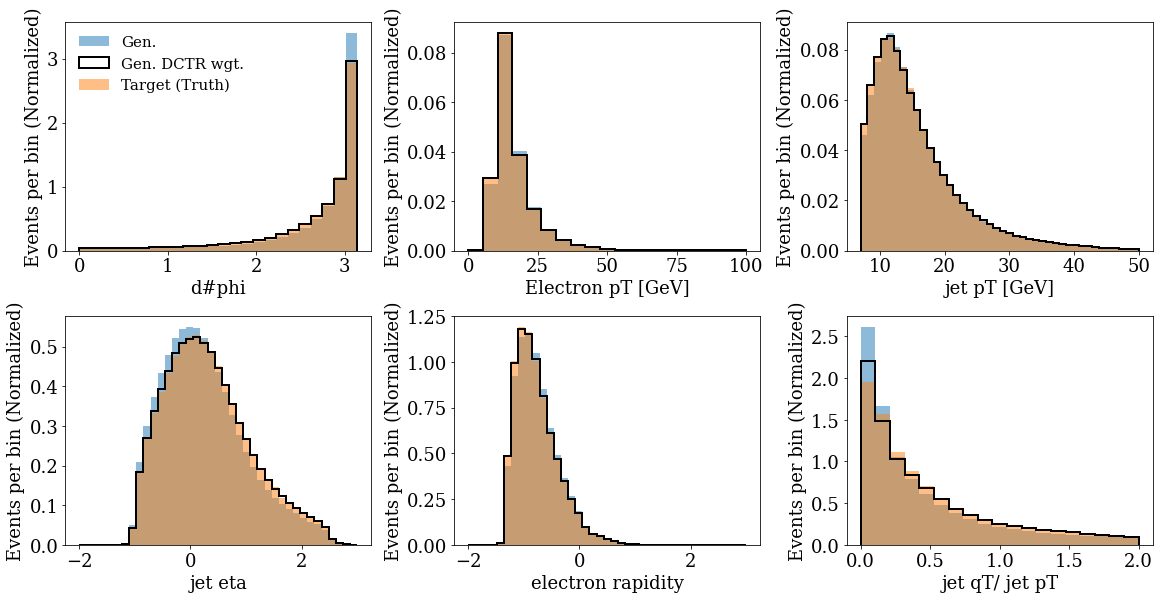

ITERATION: 2


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


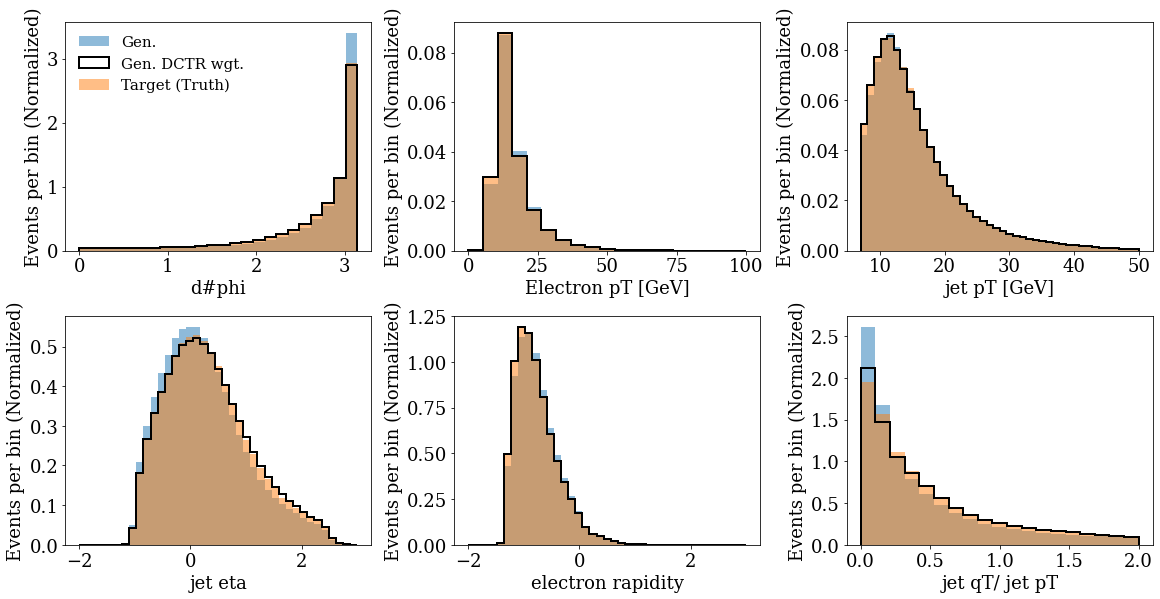

ITERATION: 3


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


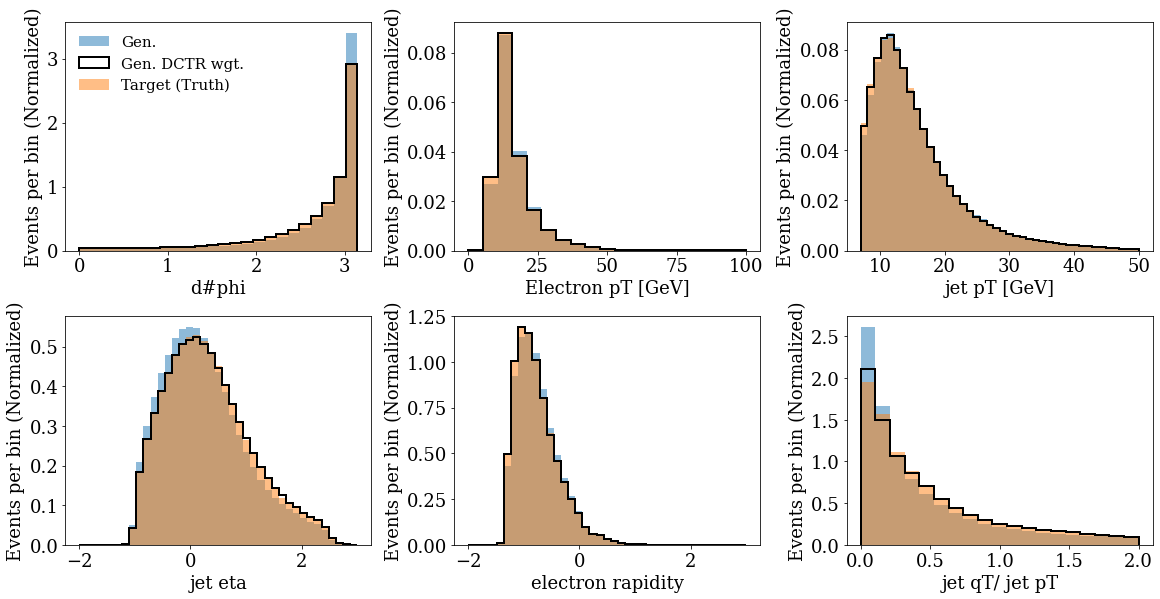

ITERATION: 4


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


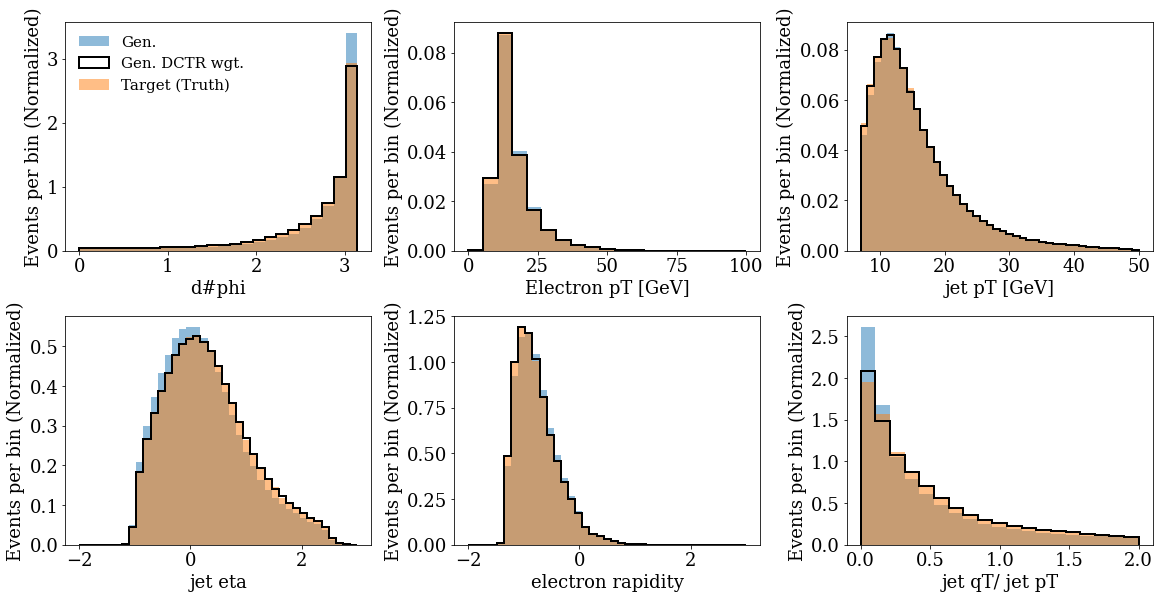

ITERATION: 5


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


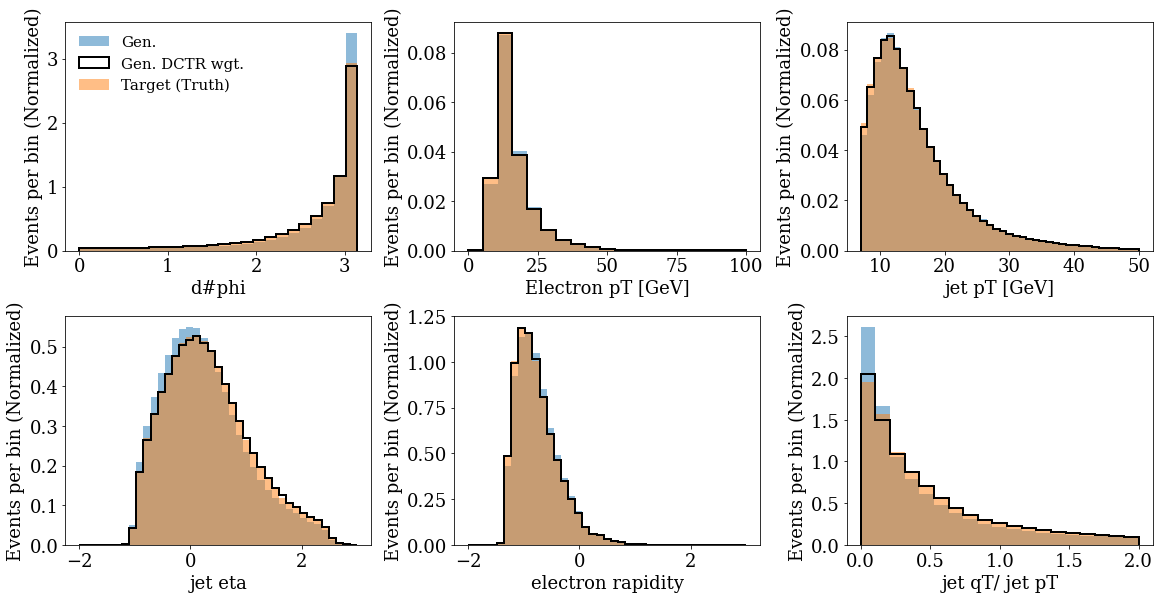

In [12]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, np.pi, 25)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           3,
                           figsize=(16, 8),
                           constrained_layout=True)
    ax[0,0].set_xlabel(r'd#phi')
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(dphi_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,0].hist(dphi_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0,0].hist(dphi_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0,0].legend(frameon=False)

    bins = np.linspace(0, 100,20)
    #bins = np.linspace(0, 2.0, 40)

    ax[0,1].set_xlabel('Electron pT [GeV]')
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(ept_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,1].hist(ept_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[0,1].hist(ept_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    #ax[1].legend(frameon=False)

    
    
    bins = np.linspace(7, 50, 43)
   # bins = np.linspace(0, 2.0, 40)

    ax[0,2].set_xlabel('jet pT [GeV]')
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(jetpt_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,2].hist(jetpt_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[0,2].hist(jetpt_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    #ax[2].legend(frameon=False)
    
    bins = np.linspace(-2.0, 3.0, 40)

    
    ax[1,0].set_xlabel('jet eta')
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(jeteta_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,0].hist(jeteta_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,0].hist(jeteta_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    
    bins = np.linspace(-2.0, 3.0, 40)

    ax[1,1].set_xlabel('electron rapidity')
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(erap_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,1].hist(erap_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,1].hist(erap_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    
    
    
    
    
    
    
    
    bins = np.linspace(0, 2.0, 20)

    
    ax[1,2].set_xlabel('jet qT/ jet pT')
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(qt_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,2].hist(qt_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,2].hist(qt_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    


    
    
    
    fig.show()
    plt.show()

In [13]:
K.clear_session()

## Define features with data

In [14]:
dphi_0_G = mc_cut['genjet_dphi']
dphi_0_S =mc_cut['jet_dphi']
dphi_unknown_S = data_cut['jet_dphi']

ept_0_G = mc_cut['gene_pt']
ept_0_S =mc_cut['e_pt']
ept_unknown_S = data_cut['e_pt']

jetpt_0_G = mc_cut['genjet_pt']
jetpt_0_S =mc_cut['jet_pt']
jetpt_unknown_S = data_cut['jet_pt']

jeteta_0_G = mc_cut['genjet_eta']
jeteta_0_S =mc_cut['jet_eta']
jeteta_unknown_S = data_cut['jet_eta']

qt_0_G = mc_cut['genjet_qtnormjetpt']
qt_0_S = mc_cut['jet_qtnormjetpt']
qt_unknown_S = data_cut['jet_qtnormjetpt']

erap_0_G = mc_cut['gene_rap']
erap_0_S = mc_cut['e_rap']
erap_unknown_S = data_cut['e_rap']


z_0_G = mc_cut['genjet_z']
z_0_S = mc_cut['jet_z']
z_unknown_S = data_cut['jet_z']

## Run unfolding on data

In [ ]:
K.clear_session()

In [ ]:
num_observables = 2

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=1,
                       theta0_G=(ept_0_G/10.0, jetpt_0_G/10.0),
                       theta0_S=(ept_0_S/10.0, jetpt_0_S/10.0),
                       theta_unknown_S=(ept_unknown_S/10.0,
                                        jetpt_unknown_S/10.0
                                        )
                      )

In [15]:
num_observables = 6

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=3,
                       theta0_G=(dphi_0_G, ept_0_G/10.0, jetpt_0_G/10.0,jeteta_0_G,qt_0_G,erap_0_G),
                       theta0_S=(dphi_0_S, ept_0_S/10.0, jetpt_0_S/10.0,jeteta_0_S, qt_0_S,erap_0_S),
                       theta_unknown_S=(dphi_unknown_S,
                                        ept_unknown_S/10.0,
                                        jetpt_unknown_S/10.0,
                                        jeteta_unknown_S,
                                        qt_unknown_S,
                                        erap_unknown_S
                                        )
                      )

In [16]:
for i in range(len(weights)):
    print (weights.shape)
    print((weights[i, 1, :]).shape)
    print((weights[i, 1, :]).shape)
    print((weights[i, 1:2, :][0]).shape)


(3, 2, 600050)
(600050,)
(600050,)
(600050,)
(3, 2, 600050)
(600050,)
(600050,)
(600050,)
(3, 2, 600050)
(600050,)
(600050,)
(600050,)


## Plot unfolded data

ITERATION: 1


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:131: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


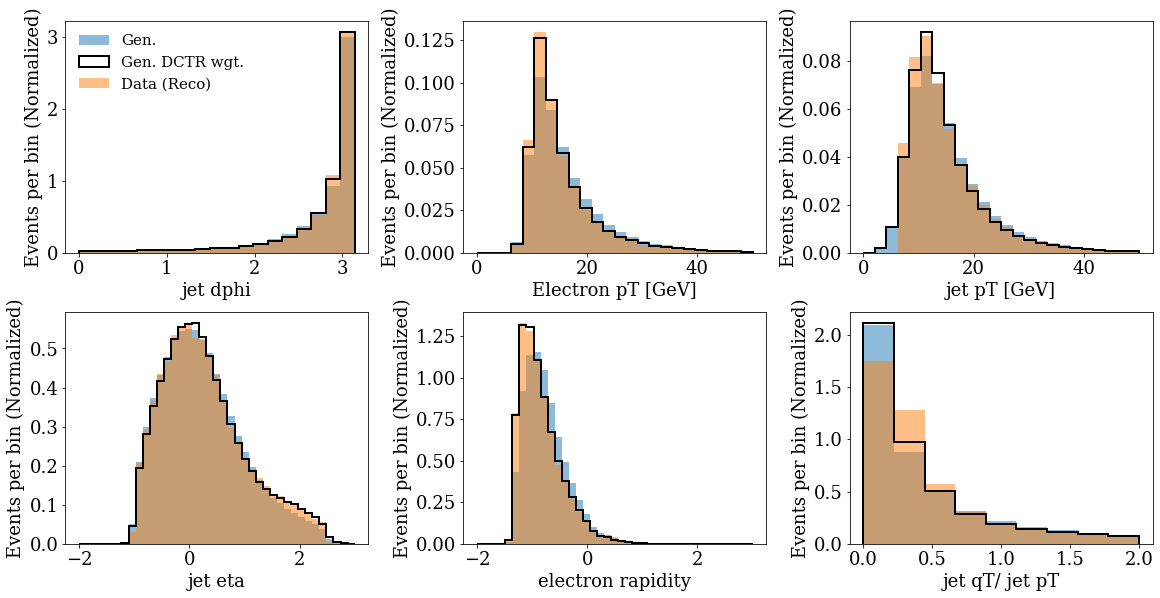

ITERATION: 2


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:131: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


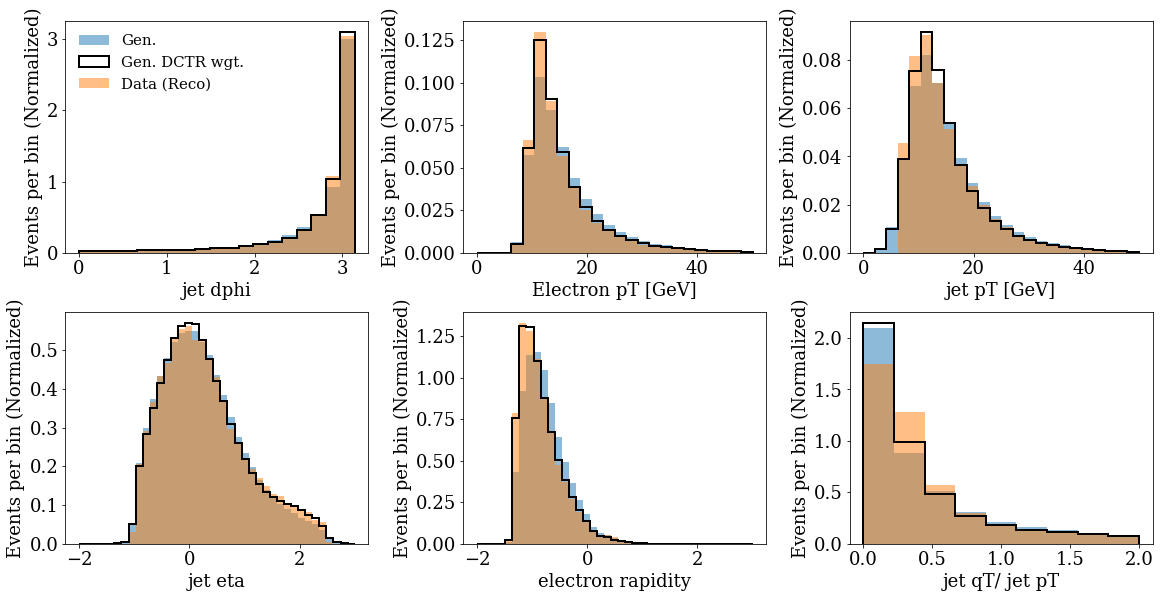

ITERATION: 3


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:131: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


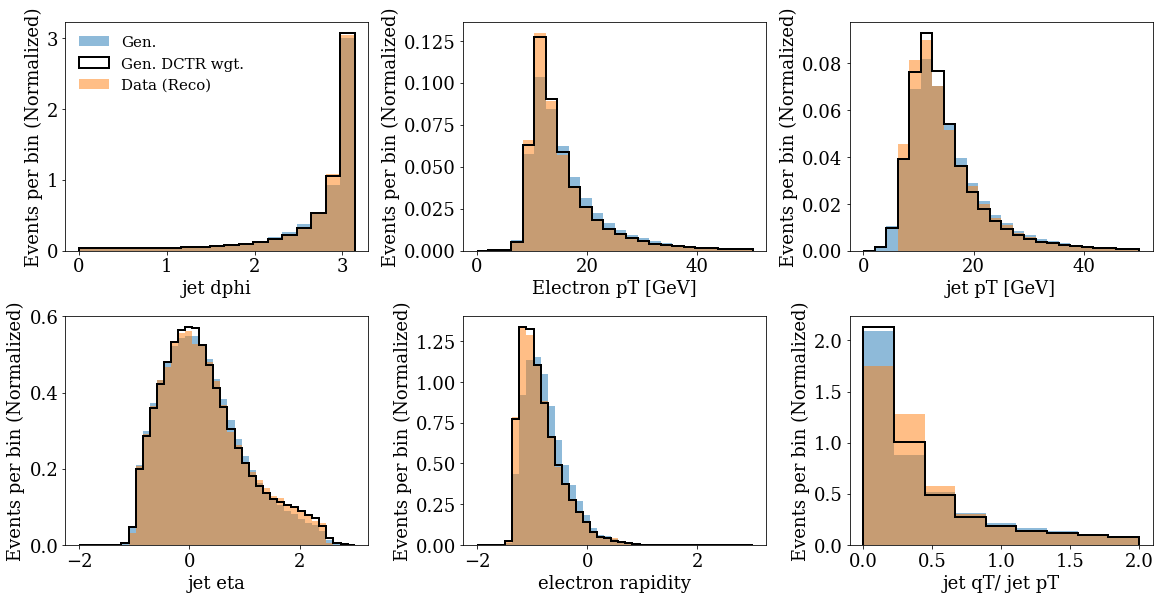

In [17]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, np.pi, 20)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           3,
                           figsize=(16, 8),
                           constrained_layout=True)
    ax[0,0].set_xlabel('jet dphi')
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(dphi_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,0].hist(dphi_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0,0].hist(dphi_unknown_S,
               bins=bins,
               label=r'Data (Reco)',
               **plot_style_2)
    ax[0,0].legend(frameon=False)

    bins = np.linspace(0, 50, 25)
    #bins = np.linspace(0, 2.0, 40)

    ax[0,1].set_xlabel('Electron pT [GeV]')
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(ept_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,1].hist(ept_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt. = Unfolded',
               **plot_style_1)
    ax[0,1].hist(ept_unknown_S,
               bins=bins,
               **plot_style_2)
    #ax[1].legend(frameon=False)

    
    
    bins = np.linspace(0, 50, 25)
   # bins = np.linspace(0, 2.0, 40)

    ax[0,2].set_xlabel('jet pT [GeV]')
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(jetpt_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,2].hist(jetpt_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[0,2].hist(jetpt_unknown_S,
               bins=bins,
               **plot_style_2)
    #ax[2].legend(frameon=False)
    
    bins = np.linspace(-2.0, 3.0, 40)

    
    ax[1,0].set_xlabel('jet eta')
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(jeteta_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,0].hist(jeteta_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,0].hist(jeteta_unknown_S,
               bins=bins,
               **plot_style_2)
    
    bins = np.linspace(-2.0, 3.0, 40)

    ax[1,1].set_xlabel('electron rapidity')
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(erap_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,1].hist(erap_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,1].hist(erap_unknown_S,
               bins=bins,
               **plot_style_2)
    
    
    
    
    
    
    
    
    bins = np.linspace(0, 2.0, 10)

    
    ax[1,2].set_xlabel('jet qT/ jet pT')
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(qt_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,2].hist(qt_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,2].hist(qt_unknown_S,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    
    #bins = np.linspace(0, 1.5, 15)

    
    #ax[2,2].set_xlabel('jet z')
    #ax[2,2].set_ylabel('Events per bin (Normalized)')
    ##ax[2,2].hist(z_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    #ax[2,2].hist(z_0_G,
    #           bins=bins,
    #           weights=weights[i, 1, :],
    #           label=r'Gen. DCTR wgt.',
    #           **plot_style_1)
    #ax[2,2].hist(z_unknown_S,
    #           bins=bins,
    #           **plot_style_2)
    

    
    
    
    fig.show()
    plt.show()

## Plot the data at reco level and the gen weighted to match the data at reco level

ITERATION: 1


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


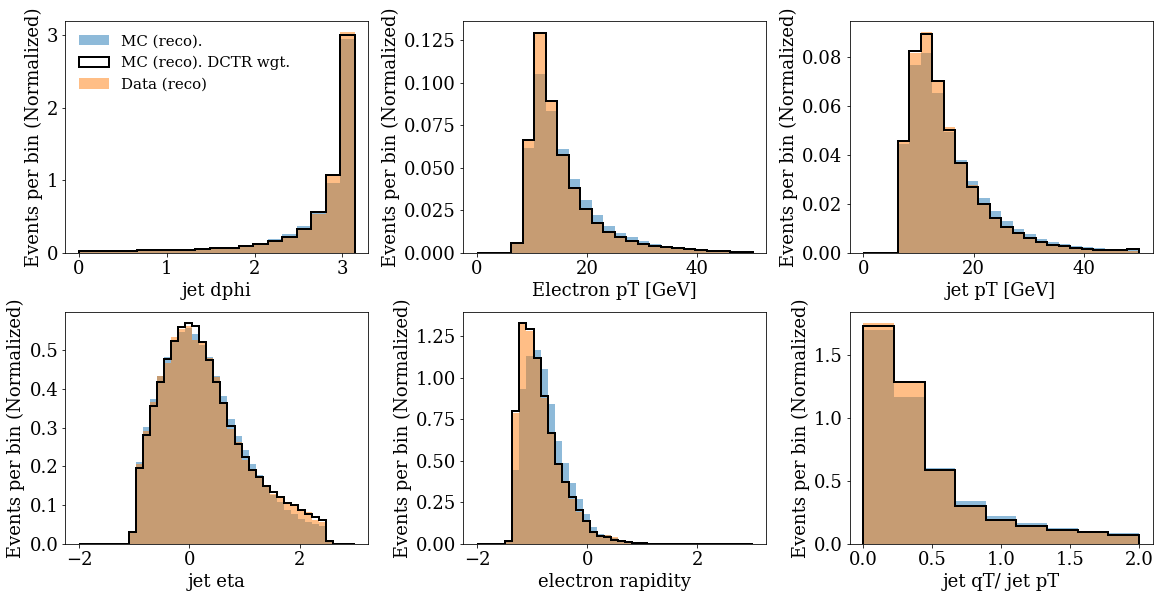

ITERATION: 2


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


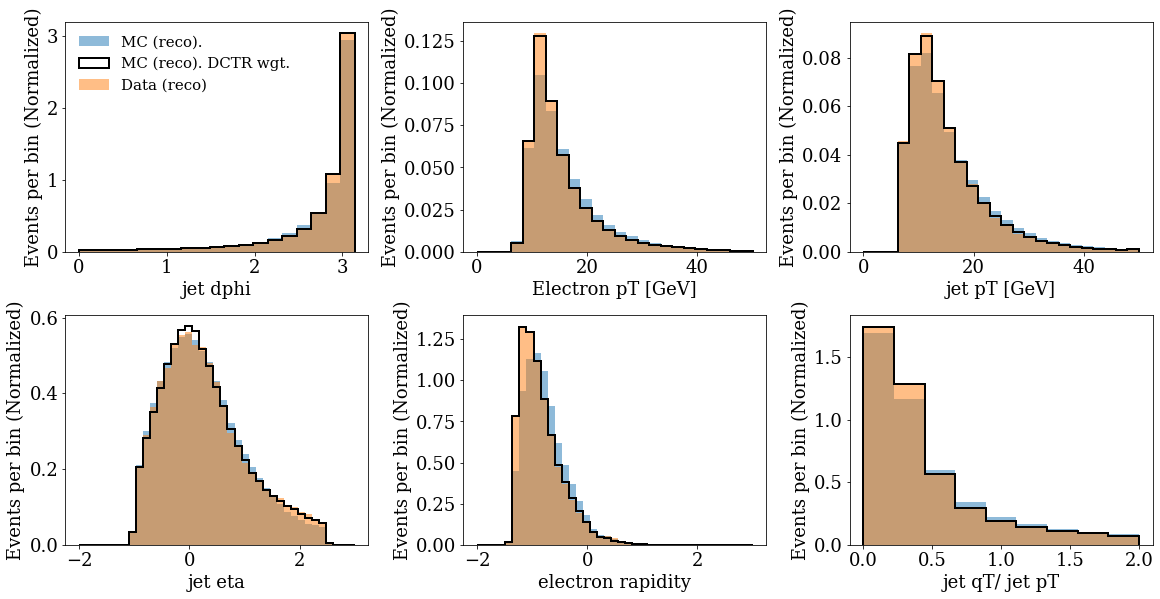

ITERATION: 3


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


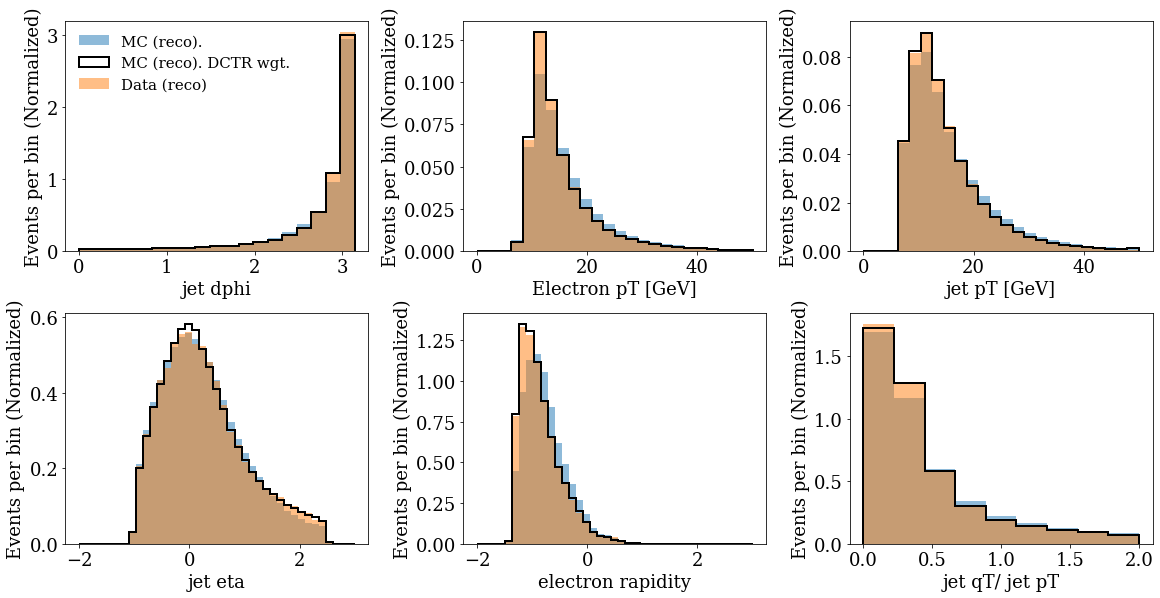

In [18]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, np.pi, 20)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           3,
                           figsize=(16, 8),
                           constrained_layout=True)
    ax[0,0].set_xlabel('jet dphi')
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(dphi_0_S, bins=bins, label=r'MC (reco).', **plot_style_2)
    ax[0,0].hist(dphi_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC (reco). DCTR wgt.',
               **plot_style_1)

    ax[0,0].hist(dphi_unknown_S,
               bins=bins,
               label=r'Data (reco)',
               **plot_style_2)
    ax[0,0].legend(frameon=False)

    
    
    
    
    
    
    bins = np.linspace(0, 50, 25)
    #bins = np.linspace(0, 2.0, 40)

    ax[0,1].set_xlabel('Electron pT [GeV]')
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(ept_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[0,1].hist(ept_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt. = Unfolded',
               **plot_style_1)
    ax[0,1].hist(ept_unknown_S,
               bins=bins,
               **plot_style_2)
    #ax[1].legend(frameon=False)

    
    
    bins = np.linspace(0, 50, 25)
   # bins = np.linspace(0, 2.0, 40)

    ax[0,2].set_xlabel('jet pT [GeV]')
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(jetpt_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[0,2].hist(jetpt_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt.',
               **plot_style_1)
    ax[0,2].hist(jetpt_unknown_S,
               bins=bins,
               **plot_style_2)
    #ax[2].legend(frameon=False)
    
    bins = np.linspace(-2.0, 3.0, 40)

    
    ax[1,0].set_xlabel('jet eta')
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(jeteta_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[1,0].hist(jeteta_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt.',
               **plot_style_1)
    ax[1,0].hist(jeteta_unknown_S,
               bins=bins,
               **plot_style_2)
    
    bins = np.linspace(-2.0, 3.0, 40)

    ax[1,1].set_xlabel('electron rapidity')
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(erap_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[1,1].hist(erap_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt.',
               **plot_style_1)
    ax[1,1].hist(erap_unknown_S,
               bins=bins,
               **plot_style_2)
    
    
    
    
    
    
    
    
    bins = np.linspace(0, 2.0, 10)

    
    ax[1,2].set_xlabel('jet qT/ jet pT')
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(qt_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[1,2].hist(qt_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt.',
               **plot_style_1)
    ax[1,2].hist(qt_unknown_S,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    
    bins = np.linspace(0, 1.5, 15)

    
    #ax[2,2].set_xlabel('jet z')
    #ax[2,2].set_ylabel('Events per bin (Normalized)')
    #ax[2,2].hist(z_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    #ax[2,2].hist(z_0_S,
    ##           bins=bins,
    #           weights=weights[i, 1:2, :][0],
    #           label=r'MC DCTR wgt.',
    #           **plot_style_1)
    #ax[2,2].hist(z_unknown_S,
    #           bins=bins,
    #           **plot_style_2)
    

    
    
    
    fig.show()
    plt.show()

## Create dataframe that includes weights

In [19]:
d = {'dphi': dphi_0_G, 'e_pt': ept_0_G, 'jet_pt': jetpt_0_G, 'weights': weights[i,1,:]}
df = pd.DataFrame(data=d)



## Plot data, and unfolded results and MC truth

## dphi 

###########
###########
###########


Text(0, 0.5, 'Normalized entries')

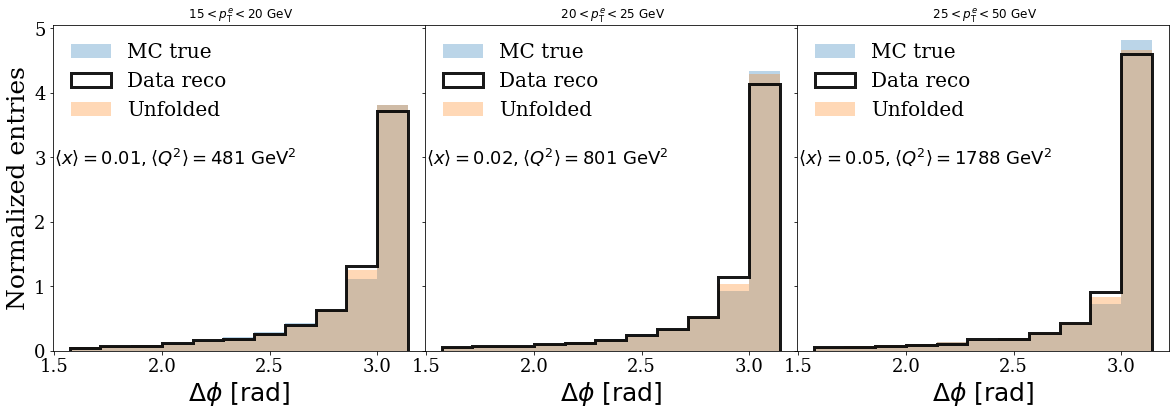

In [20]:
bins = np.linspace(np.pi/2.0, np.pi, 12)

#plt.hist(df.query('e_pt>15 and e_pt<20')['dphi'],
#               bins=bins,
#               weights=df.query('e_pt>15 and e_pt<20')['weights'],
#               label=r'Gen. DCTR wgt.',
#               **plot_style_1)



fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

nbins = 36#36
minimo = 2.8
for counter,edges in enumerate([(15,20), (20,25),(25,50)]):
    cut = 'e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1])
    df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text(r'$\Delta\phi$ $\mathrm{[rad]}$', fontsize=25)
    axs[counter].xaxis.set_label_text(r'$\Delta\phi$ $\mathrm{[rad]}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    axs[counter].hist(df_cut['dphi'],bins=bins,density=True,label='MC true',alpha=0.3)
    axs[counter].hist(data_cut.query(cut)['jet_dphi'],bins=bins,alpha=0.9,density=True, label='Data reco',color='black',lw=3,histtype='step')

    axs[counter].hist(df_cut['dphi'],bins=bins,weights=df_cut['weights'],density=True,label = 'Unfolded',alpha=0.3)

    axs[counter].legend(prop={'size': 20}, frameon=False, loc='upper left')
    axs[counter].set_title(r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$')

    axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #plt.yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


###########
###########
###########


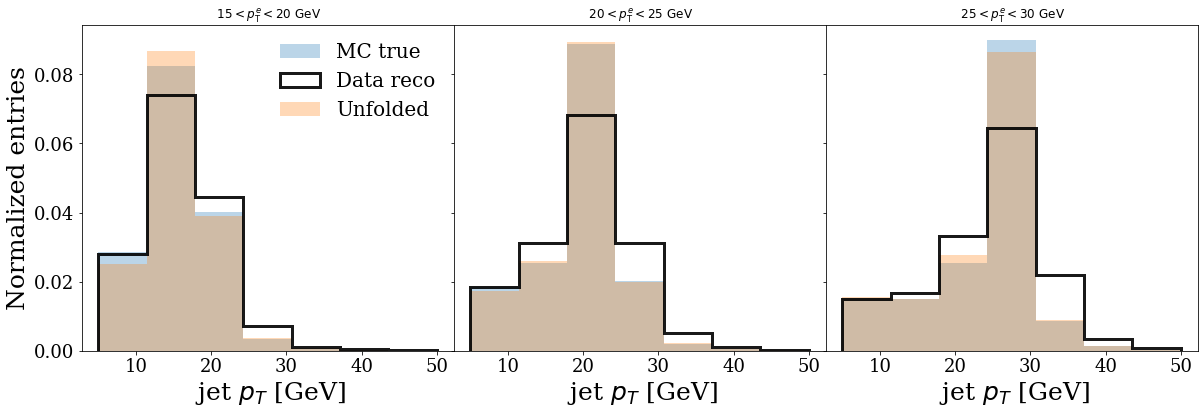

In [21]:
#bins = np.logspace(np.log10(7),np.log10(50),9)
bins = np.linspace(5,50,8)
#plt.hist(df.query('e_pt>15 and e_pt<20')['dphi'],
#               bins=bins,
#               weights=df.query('e_pt>15 and e_pt<20')['weights'],
#               label=r'Gen. DCTR wgt.',
#               **plot_style_1)



fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

nbins = 36#36
minimo = 2.8
for counter,edges in enumerate([(15,20), (20,25),(25,30)]):
    cut = 'e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1])
    df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text(r' jet $p_{T}$ [GeV]', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    axs[counter].hist(df_cut['jet_pt'],bins=bins,density=True,label='MC true',alpha=0.3)
    axs[counter].hist(data_cut.query(cut)['jet_pt'],bins=bins,alpha=0.9,density=True, label='Data reco',color='black',lw=3,histtype='step')

    axs[counter].hist(df_cut['jet_pt'],bins=bins,weights=df_cut['weights'],density=True,label = 'Unfolded',alpha=0.3)

    #axs[counter].legend(prop={'size': 20}, frameon=False, loc='upper left')
    axs[counter].set_title(r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$')

    #axs[counter].text(1.5,2.9, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
    #                  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #plt.yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)
axs[0].legend(prop={'size': 20}, frameon=False, loc='best')


###########
###########
###########


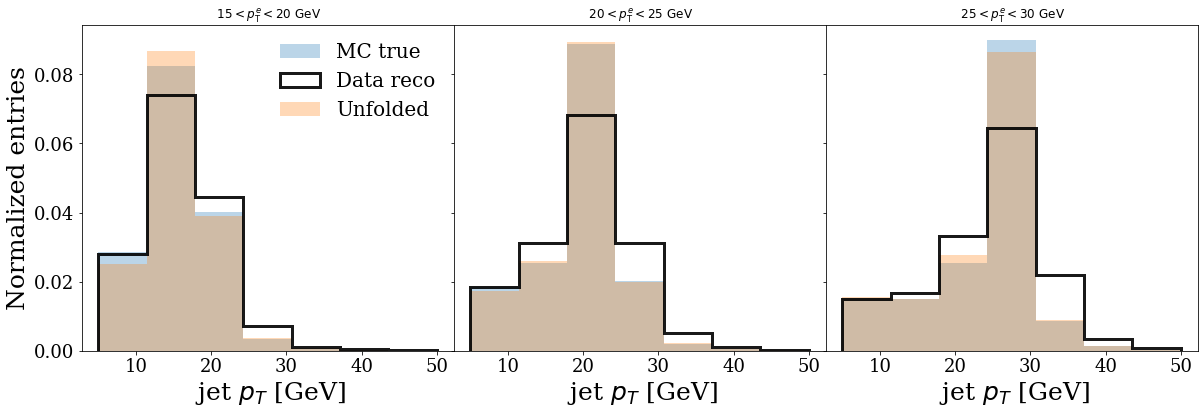

In [22]:
#bins = np.logspace(np.log10(7),np.log10(50),9)
bins = np.linspace(5,50,8)
#plt.hist(df.query('e_pt>15 and e_pt<20')['dphi'],
#               bins=bins,
#               weights=df.query('e_pt>15 and e_pt<20')['weights'],
#               label=r'Gen. DCTR wgt.',
#               **plot_style_1)



fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

nbins = 36#36
minimo = 2.8
for counter,edges in enumerate([(15,20), (20,25),(25,30)]):
    cut = 'e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1])
    df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text(r' jet $p_{T}$ [GeV]', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    axs[counter].hist(df_cut['jet_pt'],bins=bins,density=True,label='MC true',alpha=0.3)
    axs[counter].hist(data_cut.query(cut)['jet_pt'],bins=bins,alpha=0.9,density=True, label='Data reco',color='black',lw=3,histtype='step')

    axs[counter].hist(df_cut['jet_pt'],bins=bins,weights=df_cut['weights'],density=True,label = 'Unfolded',alpha=0.3)

    #axs[counter].legend(prop={'size': 20}, frameon=False, loc='upper left')
    axs[counter].set_title(r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$')

    #axs[counter].text(1.5,2.9, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
    #                  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #plt.yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)
axs[0].legend(prop={'size': 20}, frameon=False, loc='best')


In [ ]:
## Final results 

## Bootstrapping, use MC first

In [ ]:
## define MC first, these will be the same always

In [146]:
dphi_0_G = mc_cut['genjet_dphi']
dphi_0_S =mc_cut['jet_dphi']
ept_0_G = mc_cut['gene_pt']
ept_0_S =mc_cut['e_pt']
jetpt_0_G = mc_cut['genjet_pt']
jetpt_0_S =mc_cut['jet_pt']

jetz_0_G = mc_cut['genjet_z']
jetz_0_S =mc_cut['jet_z']

qt_0_G = mc_cut['genjet_qtnormjetpt']
qt_0_S = mc_cut['jet_qtnormjetpt']

In [24]:
bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
print(bootstrap_data.shape[0])
bootstrap_data.head()


57257


,isBKG,polarization,x,y,Q2,x_e,y_e,Q2_e,vertex_z,ptratio,...,jet_p,jet_pt,jet_qt,jet_dphi,jet_z,jet_eta,jet_phi,__array_index,jet_qtnormjetpt,jet_qtnormept
8438,0.0,33.759998,0.006782,0.295595,203.617630,0.006049,0.331435,203.617630,-7.709259,0.732758,...,11.961982,11.806558,0.144178,3.138335,0.632876,0.162083,5.456688,0,0.012212,0.012357
88931,0.0,-41.950001,0.003260,0.600435,198.839828,0.003315,0.590525,198.839828,-10.560303,1.032729,...,14.341983,9.507313,0.605362,3.102335,0.778874,-0.970007,1.370554,0,0.063673,0.067089
3225,0.0,27.670000,0.008310,0.306342,258.576660,0.007611,0.334505,258.576660,17.716553,0.806621,...,11.651877,11.577246,2.275760,3.005579,0.716197,-0.113486,2.069324,0,0.196572,0.173484
83628,0.0,-44.130001,0.002810,0.546576,155.982971,0.002754,0.557638,155.982971,-6.386841,1.176108,...,45.404060,10.862095,19.162182,0.052926,0.046525,2.108844,0.236774,1,1.764133,2.306840
108787,0.0,40.950001,0.010318,0.234669,245.921783,0.010494,0.230726,245.921783,10.358459,1.031886,...,16.546829,15.505148,2.114296,3.060408,1.004350,0.364538,0.470508,0,0.136361,0.153719


In [25]:
data_cut.head()

,isBKG,polarization,x,y,Q2,x_e,y_e,Q2_e,vertex_z,ptratio,...,jet_p,jet_pt,jet_qt,jet_dphi,jet_z,jet_eta,jet_phi,__array_index,jet_qtnormjetpt,jet_qtnormept
8,0.0,13.510000,0.006797,0.260711,179.986847,0.007687,0.230541,179.986847,5.684937,0.979299,...,12.719501,12.557962,1.048791,3.084810,1.230839,-0.160225,5.010220,0,0.083516,0.089120
13,0.0,16.080000,0.013004,0.258633,341.601227,0.012774,0.263293,341.601227,-9.306458,0.895417,...,18.612930,17.042835,1.586532,3.077019,0.899058,0.426018,0.689243,0,0.093091,0.100010
14,0.0,16.080000,0.023728,0.429481,1035.069092,0.023945,0.425602,1035.069092,-6.796051,1.074758,...,26.846380,26.701992,2.321808,3.136937,1.037073,0.103948,5.237698,0,0.086953,0.095222
19,0.0,16.959999,0.013761,0.315783,441.353394,0.013752,0.315979,441.353394,4.207611,1.208110,...,22.856476,21.980793,5.026038,3.038584,1.005146,0.281342,2.814812,0,0.228656,0.289266
21,0.0,16.080000,0.006225,0.370844,234.466782,0.006073,0.380108,234.466782,9.495667,1.022693,...,14.444200,14.427497,6.528921,2.676172,0.732382,-0.048114,4.837780,0,0.452533,0.541555


In [26]:
K.clear_session()

In [27]:
bootstraps = 20
iterations = 6 
nvariables = 3
weights = [] 

import timeit


for i in range(bootstraps):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    dphi_unknown_S = bootstrap_data['jet_dphi']
    ept_unknown_S = bootstrap_data['e_pt']
    jetpt_unknown_S = bootstrap_data['jet_pt']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(dphi_0_G, ept_0_G/10.0, jetpt_0_G/10.0),
                       theta0_S=(dphi_0_S, ept_0_S/10.0, jetpt_0_S/10.0),
                       theta_unknown_S=(dphi_unknown_S,
                                        ept_unknown_S/10.0,
                                        jetpt_unknown_S/10.0
                                        )
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)


0 th jackknifedata
0.0027031789995817235
1 th jackknifedata
-0.0002273820009577321
2 th jackknifedata
0.0007299700009752996
3 th jackknifedata
-0.0016316090004693251
4 th jackknifedata
-0.0035863969969796017
5 th jackknifedata
6.612997822230682e-06
6 th jackknifedata
4.544500188785605e-05
7 th jackknifedata
2.009899981203489e-05
8 th jackknifedata
7.058002665871754e-06
9 th jackknifedata
-8.357001206604764e-06
10 th jackknifedata
-1.418200190528296e-05
11 th jackknifedata
6.851899888715707e-05
12 th jackknifedata
3.9596998249180615e-05
13 th jackknifedata
0.0031645160015614238
14 th jackknifedata
0.0007823190026101656
15 th jackknifedata
-0.0002814800027408637
16 th jackknifedata
-0.00024702500013518147
17 th jackknifedata
-0.003294083999207942
18 th jackknifedata
1.7189999198308215e-05
19 th jackknifedata
7.326998456846923e-06


In [44]:
for i in range(30):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)

    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    dphi_unknown_S = bootstrap_data['jet_dphi']
    ept_unknown_S = bootstrap_data['e_pt']
    jetpt_unknown_S = bootstrap_data['jet_pt']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(dphi_0_G, ept_0_G/10.0, jetpt_0_G/10.0),
                       theta0_S=(dphi_0_S, ept_0_S/10.0, jetpt_0_S/10.0),
                       theta_unknown_S=(dphi_unknown_S,
                                        ept_unknown_S/10.0,
                                        jetpt_unknown_S/10.0
                                        )
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)

0 th jackknifedata
-0.0144142080025631
1 th jackknifedata
0.0031294139989768155
2 th jackknifedata
-0.003419891007069964
3 th jackknifedata
-0.00017470800230512396
4 th jackknifedata
-8.704000356374308e-05
5 th jackknifedata
-0.0033956660045078024
6 th jackknifedata
-8.940005500335246e-06
7 th jackknifedata
-5.063600110588595e-05
8 th jackknifedata
5.4666001233272254e-05
9 th jackknifedata
6.511800165753812e-05
10 th jackknifedata
-1.8423997971694916e-05
11 th jackknifedata
0.00039506800385424867
12 th jackknifedata
3.9726990507915616e-05
13 th jackknifedata
3.2314004783984274e-05
14 th jackknifedata
-2.6560999685898423e-05
15 th jackknifedata
4.558100044960156e-05
16 th jackknifedata
-1.6696001694072038e-05
17 th jackknifedata
2.3280008463189006e-06
18 th jackknifedata
-3.942004696000367e-06
19 th jackknifedata
-0.00013809800293529406
20 th jackknifedata
-1.2656004400923848e-05
21 th jackknifedata
7.01899261912331e-06
22 th jackknifedata
3.440000000409782e-07
23 th jackknifedata
0.000

In [45]:
for i in range(50):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)

    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    dphi_unknown_S = bootstrap_data['jet_dphi']
    ept_unknown_S = bootstrap_data['e_pt']
    jetpt_unknown_S = bootstrap_data['jet_pt']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(dphi_0_G, ept_0_G/10.0, jetpt_0_G/10.0),
                       theta0_S=(dphi_0_S, ept_0_S/10.0, jetpt_0_S/10.0),
                       theta_unknown_S=(dphi_unknown_S,
                                        ept_unknown_S/10.0,
                                        jetpt_unknown_S/10.0
                                        )
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)

0 th jackknifedata
-0.012352185978670605
1 th jackknifedata
2.2014995920471847e-05
2 th jackknifedata
5.439011147245765e-06
3 th jackknifedata
1.2550008250400424e-05
4 th jackknifedata
4.779499431606382e-05
5 th jackknifedata
-1.0622985428199172e-05
6 th jackknifedata
2.2101448848843575e-07
7 th jackknifedata
1.9682993297465146e-05
8 th jackknifedata
1.0798976290971041e-07
9 th jackknifedata
5.2306000725366175e-05
10 th jackknifedata
-8.43899033498019e-06
11 th jackknifedata
5.361197690945119e-05
12 th jackknifedata
2.2939930204302073e-06
13 th jackknifedata
-0.001035531997331418
14 th jackknifedata
4.629007889889181e-06
15 th jackknifedata
3.154001024086028e-05
16 th jackknifedata
-0.00024829299945849925
17 th jackknifedata
8.522298594471067e-05
18 th jackknifedata
8.167800842784345e-05
19 th jackknifedata
2.8153997845947742e-05
20 th jackknifedata
-9.74898284766823e-06
21 th jackknifedata
1.6156001947820187e-05
22 th jackknifedata
5.057100497651845e-05
23 th jackknifedata
-0.00099328

/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


0.0006125359941506758
33 th jackknifedata
1.5579978935420513e-05
34 th jackknifedata
1.6153004253283143e-05
35 th jackknifedata
2.6446999981999397e-05
36 th jackknifedata
2.3383006919175386e-05
37 th jackknifedata
4.15920076193288e-05
38 th jackknifedata
4.230899503454566e-05
39 th jackknifedata
8.59999272506684e-06
40 th jackknifedata
5.4140109568834305e-06
41 th jackknifedata
2.4690991267561913e-05
42 th jackknifedata
0.0002193020045524463
43 th jackknifedata
-4.350999370217323e-05
44 th jackknifedata
8.552990038879216e-06
45 th jackknifedata
0.0004493080050451681
46 th jackknifedata
9.711099846754223e-05
47 th jackknifedata
-0.001071150996722281
48 th jackknifedata
6.505298370029777e-05
49 th jackknifedata
-2.6052002795040607e-05


In [46]:
print(len(weights))

101


# for k in range(bootstraps):
#    for i in range(len(weights[k])):
        #print (weights[k].shape)
        #print((weights[k][i, 1, :]).shape)
        #print((weights[k][i, 1, :]).shape)
        #print((weights[k][i, 1:2, :][0]).shape)
print(myns[:,1])

In [273]:
bins = np.flip(2*np.pi - np.logspace(np.log10(np.pi),np.log10(2*np.pi),15)) 
print (bins)


[0.         0.3035083  0.59235569 0.86725034 1.12886625 1.37784484
 1.61479657 1.84030237 2.05491515 2.25916109 2.45354097 2.63853135
 2.8145858  2.98213597 3.14159265]


In [230]:
bins = np.flip( 2- np.logspace(np.log10(1),np.log10(2.0),6)) 
print(bins)

[0.         0.25889887 0.48428343 0.68049209 0.85130165 1.        ]


In [160]:
bins = np.linspace(0.0,2.0,10) 
bins = np.append(bins,inf)
print(bins)

[0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
 1.33333333 1.55555556 1.77777778 2.                inf]


In [184]:
bins = np.logspace(np.log(1.0),np.log10(5.0),12) -1
print(bins)

[0.         0.15755791 0.33994032 0.55105852 0.79544006 1.07832585
 1.40578253 1.7848326  2.223605   2.73150948 3.31943832 4.        ]


In [218]:
bins = np.logspace(np.log(1.0),np.log10(2.0),6) -1
print(bins)

[0.         0.14869835 0.31950791 0.51571657 0.74110113 1.        ]


In [ ]:
covariance_matrices = []
for it in range(6):
    myns = []
    #bins = np.logspace(np.log10(0.1),np.log10(1.0),8)
    #bins = np.logspace(np.log10(0.1),np.log10(np.pi),20)
    #bins = np.array([0.0, 2.05491515, 2.45354097, 2.63853135,
    #                 2.8145858,  2.98213597, 3.14159265])

    bins = np.logspace(np.log10(7),np.log10(50),6)
    #bins = np.flip(2*np.pi - np.logspace(np.log10(np.pi),np.log10(2*np.pi),15)) 

    #bins = np.logspace(np.log(1.0),np.log10(5.0),12) -1
    #bins = np.array([0., 0.1,0.2, 0.33994032, 0.55105852  ,1.07832585,2.0])
    #bins = np.flip( 2- np.logspace(np.log10(1),np.log10(2.0),5)) 

    #bins = np.append(bins,inf)

    for k in range(len(weights)):
        n,b,_ = plt.hist(jetpt_0_S,bins=bins,weights=weights[k][it, 1, :],alpha=0.3)
        myns+=[n]
        pass
    myns = np.array(myns)
    #print(myns)
    plt.xlabel('jet pT [GeV]')

    cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])
    corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

    covariance_matrices.append(corr)
    #fig, ax = plt.subplots() 
    #im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
    #                         interpolation='none')
    #fig.colorbar(im,ax=ax)

print(covariance_matrices[0])
plt.show()

#print (len(myns))
#print (len(myns[0]))

[0.         0.1        0.2        0.33994032 0.55105852 1.07832585
 2.        ]


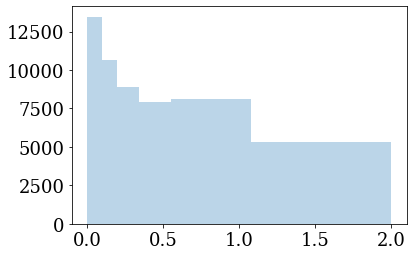

In [216]:
#bins = np.flip(2*np.pi - np.logspace(np.log10(np.pi),np.log10(2*np.pi),15)) 
#
#bins = np.array([0.0,1.37784484, 1.84030237, 2.05491515, 2.25916109, 2.45354097, 2.63853135,
# 2.8145858,  2.98213597, 3.14159265])
bins = np.array([0., 0.1,0.2, 0.33994032, 0.55105852 ,1.07832585,2.0])
print(bins)
n,b,_ = plt.hist(qt_0_G,bins=bins,weights=weights[0][-1, 1, :],alpha=0.3)
#plt.yscale('log')
#plt.xscale('log')

[0.         0.09050773 0.18920712 0.29683955 0.41421356 0.54221083
 0.68179283 0.83400809 1.        ]


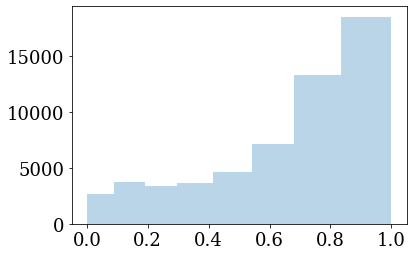

In [225]:
bins = np.logspace(np.log(1.0),np.log10(2.0),9) -1
print(bins)
n,b,_ = plt.hist(z_0_G,bins=bins,weights=weights[0][-1, 1, :],alpha=0.3)

In [208]:
weights[75][it, 1, :] = 0

/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6699: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


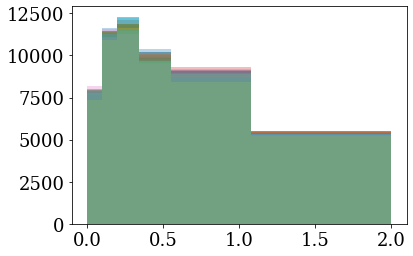

In [215]:
for k in range(80):
    n,b,_ = plt.hist(qt_0_S,bins=bins,weights=weights[k][-1, 1, :],alpha=0.3)

In [ ]:
print(covariance_matrices[0])
print(covariance_matrices[1])
print(covariance_matrices[2])


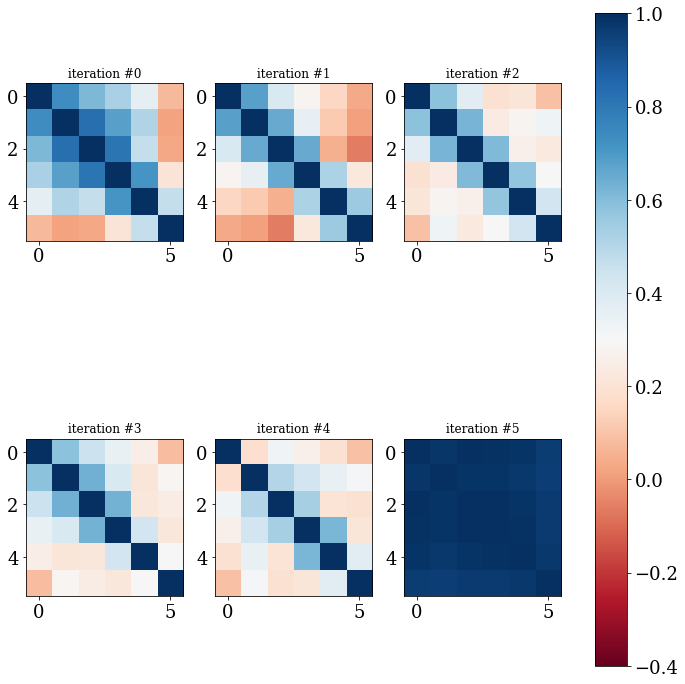

In [277]:
fig, ax = plt.subplots(2,3,figsize=(12,12)) 
minimo =-.40
maximo = 1.0
im = ax[0,0].imshow(covariance_matrices[0],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[0,1].imshow(covariance_matrices[1],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[0,2].imshow(covariance_matrices[2],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
im = ax[1,0].imshow(covariance_matrices[3],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
im = ax[1,1].imshow(covariance_matrices[4],cmap='RdBu', vmin=minimo, vmax =1.0,
                  interpolation='none')
im = ax[1,2].imshow(covariance_matrices[5],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')


ax[0,0].set_title('iteration #0')
ax[0,1].set_title('iteration #1')
ax[0,2].set_title('iteration #2')
ax[1,0].set_title('iteration #3')
ax[1,1].set_title('iteration #4')
ax[1,2].set_title('iteration #5')


plt.colorbar(im,ax=ax)
plt.show()

In [235]:
covariance_matrices[4]

array([[1.        , 0.15291668, 0.07617916, 0.15175323],
       [0.15291668, 1.        , 0.92735221, 0.73408064],
       [0.07617916, 0.92735221, 1.        , 0.86990985],
       [0.15175323, 0.73408064, 0.86990985, 1.        ]])

In [268]:
from numpy.linalg import inv
x = [] 
rhos= []
for it in range(6): #iterations
    temp = []
    cov = np.matrix(covariance_matrices[it])
    inversecov = inv(cov)
    for i in range(cov.shape[0]):
         if(cov[i,i]*inversecov[i,i]!=0):
            temp.append( np.sqrt(1- 1.0/(cov[i,i]*inversecov[i,i])))
    rho_it = np.average(temp)
    rhos.append(rho_it)
    x.append(it)
    print (rho_it)
print (x)
print (rhos)

0.870991585293127
0.8138264789880157
0.7718788479192525
0.6055104081652259
0.4351401316173183
0.9541188919766855
[0, 1, 2, 3, 4, 5]
[0.870991585293127, 0.8138264789880157, 0.7718788479192525, 0.6055104081652259, 0.4351401316173183, 0.9541188919766855]


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

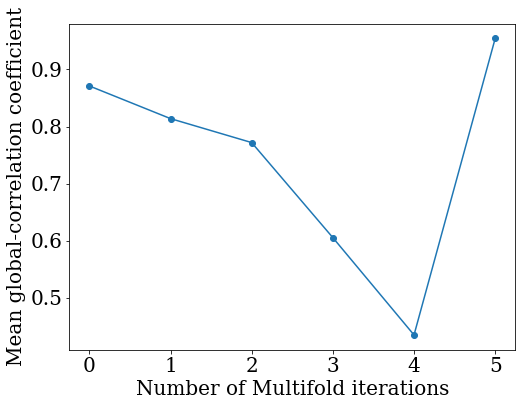

In [278]:
fig = plt.figure(figsize=(8,6))
plt.plot(x,rhos,'-o')
plt.xlabel('Number of Multifold iterations',fontsize=20)
plt.ylabel('Mean global-correlation coefficient',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [ ]:
cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
fig, ax = plt.subplots() 
im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
                             interpolation='none')
fig.colorbar(im,ax=ax)
plt.show()

In [ ]:
print(corr)

In [73]:

l = dphi_unknown_S
for i in range(10):
    ll = np.random.choice(l, size=l.shape, replace=False) 
    print(ll)
    print(len(ll))

[2.9883723 3.0533364 2.9917378 ... 3.05885   2.8658526 1.8024942]
57049
[0.77880996 3.0289562  2.8322031  ... 2.956968   3.052418   3.031959  ]
57049
[3.003862   1.365811   0.72824943 ... 2.9416327  2.8554866  3.0719843 ]
57049
[3.0348332 2.7519968 3.103597  ... 2.9531474 2.5578954 2.7659805]
57049
[2.515481  3.0868897 2.3962414 ... 2.2822447 2.916079  2.964833 ]
57049
[3.141252  2.9483376 3.1046126 ... 3.0765858 3.0358605 2.8719368]
57049
[1.4634757 3.0339985 2.8915057 ... 2.889078  2.9960914 2.3439624]
57049
[3.0699422 2.6907315 1.2929811 ... 2.9285235 3.1232984 3.0450866]
57049
[2.9077067 2.9632583 2.3345737 ... 2.9861307 1.7921137 3.0563457]
57049
[2.967088  3.1091113 2.8744905 ... 0.7175196 3.083634  2.3318512]
57049


In [74]:
np.mean(ll)

2.7474458